In [7]:
import os
import sys
import warnings
import logging
from collections import defaultdict
import signal
import atexit


# Typing
from typing import List, Dict

# Hydra & config
import hydra
from omegaconf import OmegaConf, DictConfig

# JAX & Equinox
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import wandb
import jax.profiler
import numpy as np

# Foundational SSM core imports
from foundational_ssm.data_utils import get_brainset_train_val_loaders, get_dataset_config
from foundational_ssm.models import SSMFoundationalDecoder
from foundational_ssm.constants import DATASET_IDX_TO_GROUP_SHORT
from foundational_ssm.utils.training import get_filter_spec, create_cosine_annealing_scheduler, mse_loss_foundational, make_step_foundational, predict_batch
from foundational_ssm.metrics import compute_r2_standard
from foundational_ssm.utils.wandb_utils_jax import save_checkpoint_wandb, load_checkpoint_wandb, save_best_model_wandb
from foundational_ssm.utils.training_utils import (
    log_batch_metrics, track_batch_timing, 
    setup_wandb_metrics, log_epoch_summary, compute_r2_by_groups,
    prepare_batch_for_training, extract_batch_data
)

import warnings
import traceback
import sys

import multiprocessing as mp

import h5py
import torch
import time
import psutil
import logging

logging.basicConfig(filename='pretrain_decoding.log', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)
WARNING_LOG_FILE = "warnings.log"

# Global variables for signal handling
interrupted = False
current_training_state = None  # Will store (model, state, opt_state, epoch, current_step, run_name)

def signal_handler(signum, frame):
    """Handle interruption signals gracefully"""
    global interrupted
    print(f"[WARNING] Received signal {signum}. Saving checkpoint before exit...")
    interrupted = True

def save_interrupted_checkpoint():
    """Save checkpoint when interrupted"""
    global current_training_state
    if current_training_state is not None:
        model, state, opt_state, epoch, current_step, run_name, metrics = current_training_state
        metadata = {}
        if metrics:
            metadata.update(metrics)
        metadata.update({
            'train_loss': 0.0,  # Will be updated if we have it
            'interrupted': True,
            'interruption_epoch': epoch,
            'interruption_step': current_step
        })
        try:
            save_checkpoint_wandb(model, state, opt_state, epoch, current_step, metadata, run_name)
            print(f"[INFO] Checkpoint saved at epoch {epoch}, step {current_step} due to interruption")
        except Exception as e:
            print(f"[ERROR] Failed to save checkpoint: {e}")

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    with open(WARNING_LOG_FILE, "a") as log:
        traceback.print_stack(file=log)
        log.write(warnings.formatwarning(message, category, filename, lineno, line))

    

# Remove this function since it's now imported from training_utils

def train_one_batch(batch, model, state, filter_spec, loss_fn, opt, opt_state, train_key, lr_scheduler, current_step):
    batch = prepare_batch_for_training(batch)
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    dataset_group_idxs = batch["dataset_group_idx"]
    mask = batch["mask"]
    
    key, subkey = jr.split(train_key)
    model, state, opt_state, loss_value, grads = make_step_foundational(
        model, state, filter_spec, inputs, targets, mask,
        loss_fn, opt, opt_state, subkey, dataset_group_idxs,
    )
    
    current_lr = lr_scheduler(current_step)
    wandb.log({
        "train/loss": loss_value,
        "train/learning_rate": current_lr,
    }, step=current_step)
    return model, state, opt_state, loss_value

def train_one_epoch(train_loader, model, state, filter_spec, loss_fn, opt, opt_state, train_key, lr_scheduler, current_step, epoch):    
    epoch_loss = 0
    batch_count = 0
    minute_start_time = time.time()
    prev_time = time.time()
    
    for batch_idx, batch in enumerate(train_loader):
        data_load_time = time.time() - prev_time
        batch_process_start = time.time()
        
        model, state, opt_state, loss_value = train_one_batch(
            batch, model, state, filter_spec, loss_fn, opt, opt_state, train_key, lr_scheduler, current_step
        )
        batch_process_end = time.time()
        batch_process_time = batch_process_end - batch_process_start
        
        log_batch_metrics(data_load_time, batch_process_time, epoch, current_step)
        epoch_loss += loss_value
        batch_count += 1
        current_time = time.time()
        batch_count, minute_start_time = track_batch_timing(batch_count, minute_start_time, current_time, current_step)
        prev_time = time.time()
        current_step += 1
    
    wandb.log({"train/epoch_loss": epoch_loss, "epoch": epoch}, step=current_step)
    return model, state, opt_state, current_step, epoch_loss
    


def validate_one_epoch(val_loader, model, state, val_key, DATASET_IDX_TO_GROUP_SHORT, compute_r2_standard, epoch, current_step):
    print("[INFO] Validating one epoch")
    metrics = {}  # New: store metrics per group
    all_preds = []
    all_targets = []
    all_dataset_group_idxs = []
    val_start_time = time.time()
    prev_time = time.time()
    for batch_idx, batch in enumerate(val_loader):
        data_load_time = time.time() - prev_time
        batch_process_start = time.time()
        batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
        dataset_group_idxs = batch["dataset_group_idx"]
        inputs = batch["neural_input"]
        targets = batch["behavior_input"]
        mask = batch["mask"]
        mask = mask[..., None]

        key, subkey = jr.split(val_key)
        batch_keys = jr.split(subkey, inputs.shape[0])
        preds, state = jax.vmap(model, axis_name="batch", in_axes=(0, None, 0, 0), out_axes=(0, None))(inputs, state, batch_keys, dataset_group_idxs)

        all_preds.append(jnp.where(mask, preds, 0))
        all_targets.append(jnp.where(mask, targets, 0))
        all_dataset_group_idxs.append(dataset_group_idxs)
        batch_process_end = time.time()
        batch_process_time = batch_process_end - batch_process_start
        print(f"Batch size: {inputs.shape[0]}, Batch time dimension: {inputs.shape[1]}, Batch {batch_idx} data load time: {data_load_time:.2f}s, batch process time: {batch_process_time:.2f}s")
        prev_time = time.time()


    all_preds = jnp.concatenate(all_preds, axis=0)
    all_targets = jnp.concatenate(all_targets, axis=0)
    all_dataset_group_idxs = jnp.concatenate(all_dataset_group_idxs, axis=0)
    unique_dataset_group_idxs = jnp.unique(all_dataset_group_idxs)
    for dataset_group_idx in unique_dataset_group_idxs:
        dataset_group_idx = int(dataset_group_idx)
        dataset_group_short_name = DATASET_IDX_TO_GROUP_SHORT[dataset_group_idx]
        dataset_group_mask = all_dataset_group_idxs == dataset_group_idx
        preds = all_preds[dataset_group_mask]
        targets = all_targets[dataset_group_mask]
        r2_score = compute_r2_standard(preds, targets)
        metrics[f"val/r2_{dataset_group_short_name}"] = float(r2_score)
    
    r2_score = compute_r2_standard(all_preds, all_targets)
    metrics['val/r2_avg'] = float(np.mean([metrics[key] for key in metrics.keys() if "r2" in key]))
    metrics['val/r2_all'] = float(r2_score)

    # Log validation timing and resources
    val_end_time = time.time()
    val_time = val_end_time - val_start_time
    metrics['val/time'] = val_time
    metrics['epoch'] = epoch

    wandb.log(metrics, step=current_step)
    return metrics


@hydra.main(config_path="../configs", config_name="pretrain", version_base="1.3")
def main(cfg: DictConfig):
    warnings.showwarning = warn_with_traceback
    mp.set_start_method("spawn", force=True)

    print(OmegaConf.to_yaml(cfg))

    # Load dataset
    train_dataset, train_loader, val_dataset, val_loader = get_brainset_train_val_loaders(
        train_config=cfg.train_dataset_config,
        val_config=cfg.val_dataset_config,
        **cfg.dataloader
    )

    key, train_key, val_key = jr.split(jr.PRNGKey(cfg.rng_seed), 3)

    model = SSMFoundationalDecoder(
            **cfg.model
        )
    state = eqx.nn.State(model)

    filter_spec = get_filter_spec(
        model,
        **cfg.filter_spec
    )
    
    
    if cfg.optimizer.use_cosine_scheduler:
        total_steps = len(train_loader) * cfg.training.epochs
        lr_scheduler = create_cosine_annealing_scheduler(
            initial_lr=cfg.optimizer.lr,
            total_steps=total_steps,
            min_lr=getattr(cfg.optimizer, 'min_lr', 0.0),  # Default to 0.0 if not specified
            warmup_steps=getattr(cfg.optimizer, 'warmup_steps', 0)  # Default to 0 if not specified
        )
    else:
        lr_scheduler = lambda step: cfg.optimizer.lr
    
    opt = optax.chain(
        optax.adamw(learning_rate=lr_scheduler, weight_decay=cfg.optimizer.weight_decay)
    )
    opt_state = opt.init(eqx.filter(model, filter_spec))
    
    loss_fn = mse_loss_foundational
    
    run_name = f"{cfg.wandb.run_prefix}_l{cfg.model.ssm_num_layers}_d{cfg.model.ssm_dim}"
    config_dict = OmegaConf.to_container(cfg, resolve=True)
    
    # Track current step for scheduler and best r2 score
    current_step = 0
    best_r2_score = 0.0

    if cfg.wandb.resume_run_id is not None:
        # Resume existing wandb run
        wandb.init(entity=cfg.wandb.entity, project=cfg.wandb.project, id=cfg.wandb.resume_run_id, resume="allow")
        setup_wandb_metrics()
        
        # Load checkpoint
        model, state, opt_state, last_epoch, current_step, checkpoint_metadata = load_checkpoint_wandb(
            path=None,  # path is ignored, wandb is used
            model_template=model,
            state_template=state,
            opt_state_template=opt_state,
            wandb_run_name=run_name,
            wandb_project=cfg.wandb.project,
            wandb_entity=cfg.wandb.entity,
        )
        start_epoch = last_epoch + 1
        # Load best R² score from checkpoint metadata if available
        best_r2_score = checkpoint_metadata.get('best_r2_score', 0.0)
    else:
        # Start new wandb run
        wandb.init(project=cfg.wandb.project, name=run_name, config=config_dict) 
        setup_wandb_metrics()
        start_epoch = 0

    for epoch in range(start_epoch, cfg.training.epochs):
        # Check for interruption
        print(f"[DEBUG] main: Running training for epoch {epoch}")
        model, state, opt_state, current_step, epoch_loss = train_one_epoch(
                train_loader, model, state, filter_spec, loss_fn, opt, opt_state, train_key, lr_scheduler, current_step, epoch
            )
    
        if epoch % cfg.training.checkpoint_every == 0:
            print(f"[DEBUG] main: Running validation for epoch {epoch}")
            metrics = validate_one_epoch(
                val_loader, model, state, val_key, DATASET_IDX_TO_GROUP_SHORT, compute_r2_standard, epoch, current_step
            )
            
            # Track best R² score
            current_r2_avg = metrics.get('val/r2_avg', 0.0)
            if current_r2_avg > best_r2_score:
                best_r2_score = current_r2_avg
                print(f"[DEBUG] main: New best R² score: {best_r2_score:.4f} at epoch {epoch}")
                save_best_model_wandb(model, run_name, OmegaConf.to_container(cfg.model, resolve=True))
            
            metadata = metrics
            metadata.update({
                'train_loss': epoch_loss,
                'best_r2_score': best_r2_score,
                'interrupted': False
            })
            
            # Update global state for signal handling
            global current_training_state
            current_training_state = (model, state, opt_state, epoch, current_step, run_name, metrics)
            
            print(f"[DEBUG] main: Saving checkpoint for epoch {epoch}")
            save_checkpoint_wandb(model, state, opt_state, epoch, current_step, metadata, run_name)
    
    # jax.profiler.stop_trace()
    wandb.finish()
    
    print("[DEBUG] main: Training completed successfully")
          

In [8]:
import sys 
from foundational_ssm.constants import DATA_ROOT

# sys.path.append("..")
config_path = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/test_pretrain.yaml"
cfg = OmegaConf.load(config_path) 
warnings.showwarning = warn_with_traceback
mp.set_start_method("spawn", force=True)

print(OmegaConf.to_yaml(cfg))

# Load dataset
train_dataset, train_loader, val_dataset, val_loader = get_brainset_train_val_loaders(
    train_config=cfg.train_dataset_config,
    val_config=cfg.val_dataset_config,
    **cfg.dataloader,
    root="../"+DATA_ROOT
)

key, train_key, val_key = jr.split(jr.PRNGKey(cfg.rng_seed), 3)

model = SSMFoundationalDecoder(
        **cfg.model
    )
state = eqx.nn.State(model)

filter_spec = get_filter_spec(
    model,
    **cfg.filter_spec
)


if cfg.optimizer.use_cosine_scheduler:
    total_steps = len(train_loader) * cfg.training.epochs
    lr_scheduler = create_cosine_annealing_scheduler(
        initial_lr=cfg.optimizer.lr,
        total_steps=total_steps,
        min_lr=getattr(cfg.optimizer, 'min_lr', 0.0),  # Default to 0.0 if not specified
        warmup_steps=getattr(cfg.optimizer, 'warmup_steps', 0)  # Default to 0 if not specified
    )
else:
    lr_scheduler = lambda step: cfg.optimizer.lr

opt = optax.chain(
    optax.adamw(learning_rate=lr_scheduler, weight_decay=cfg.optimizer.weight_decay)
)
opt_state = opt.init(eqx.filter(model, filter_spec))

loss_fn = mse_loss_foundational

run_name = f"{cfg.wandb.run_prefix}_l{cfg.model.ssm_num_layers}_d{cfg.model.ssm_dim}"
config_dict = OmegaConf.to_container(cfg, resolve=True)

# Track current step for scheduler and best r2 score
current_step = 0
best_r2_score = 0.0

wandb:
  project: foundational_ssm_pretrain_decoding
  run_prefix: possm_dataset
  tags:
  - neural
  - behavior
  - masking
  entity: melinajingting-ucl
  resume_run_id: null
train_dataset_config: /cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/dataset/possm_pretrain.yaml
val_dataset_config: /cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/dataset/possm_pretrain.yaml
dataloader:
  train_batch_size: 64
  val_batch_size: 64
  lazy: true
  num_workers: 4
  keep_files_open: false
  train_window_length: 1.0
  val_window_length: 5.0
  drop_short: true
  sampling_rate: 200
model:
  ssm_io_dim: 64
  ssm_dim: 64
  ssm_init_diag_blocks: 4
  ssm_num_layers: 4
  output_dim: 2
  rng_seed: 42
optimizer:
  lr: 0.001
  weight_decay: 0.001
  use_cosine_scheduler: false
  min_lr: 1.0e-05
  warmup_steps: 100
training:
  epochs: 1000
  checkpoint_every: 50
filter_spec:
  freeze_ssm: false
  freeze_mlp: false
rng_seed: 42
device: cuda



In [ ]:
for batch_idx, batch in enumerate(train_loader):
    batch = prepare_batch_for_training(batch)
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    dataset_group_idxs = batch["dataset_group_idx"]
    mask = batch["mask"]
    
    key, subkey = jr.split(train_key)
    batch_keys = jr.split(key, inputs.shape[0])
    preds, state = jax.vmap(model, axis_name="batch", in_axes=(0, None, 0, 0), out_axes=(0, None))(inputs, state, batch_keys, dataset_group_idxs)
    
    model_params, model_static = eqx.partition(model, filter_spec)
    (value, state), grads = loss_fn(model_params, model_static, state, inputs, targets, mask, dataset_group_idxs, key)
    print(value)
    if value >999999:
        break
    
    

/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


24760.441
9102.648
15198.29
23583.26
15292.083
19731.754
7387.5884
17983.178
9747.285
14602.592
14397.948
6932.573
14577.699
11753.167
15269.738
13508.061
18817.885
20906.807
10093.816
13393.609
8274.614
11272.224
11402.067
21131.926
9521.192
15241.286
14572.156
16224.826
11163.138
13253.012
5863.4067
14432.7
13854.429
10534.323
4363.594
11087.787
11570.022
16289.913
18699.877
6779.473
20062.81
13087.464
13240.218
10643.99
11809.63


/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


23428.248
7586.381
24101.246
14157.791
3479.2278
16179.497
18622.43
19963.074
14306.417
12114.01
26321.957
9216.563
10425.301
18211.607
16032.229
12247.961
16628.59
10973.002
11814.996
21916.08


/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


11911.013
8250.464
25612.715
14439.735
9146.171
20263.348
9601.491
13511.544
8677.982
11619.046
9663.874
8742.231
39427.402
12800.262
15143.108
14445.429
10604.947
16498.95
10740.835
11696.44
14237.705
4611.9917
4788.771
8555.022
11098.552
11371.854
14549.855
19591.342
11683.271
11647.403
13216.162
14220.9375
9907.533
10863.052
11692.213
12432.101
10794.631
16899.246
10868.156
12873.602
18473.566
7720.9795
14060.749
12128.499
10836.983
6694.116
10894.074
11165.028
18141.709
10531.991
15997.358
15323.164
23155.053
17740.012
12136.589
9631.875
15299.063
7897.381
17403.553
12072.567
14308.296
13397.184
10723.399
11780.058
21203.518
9615.979
15422.308
14483.32
10662.957
18095.879
10452.016
15584.136
16683.393
10856.541
15448.898
12913.271
21426.805
8324.154
18984.127
13062.51
15828.353
10566.566
12398.764
7242.138
21279.836
9811.843
10418.195
17186.63
9286.519
14703.85
21657.941
12428.666
21220.748
14505.782
14532.208
7669.3677
11732.619
12433.1455
16000.917
14216.531
12478.478
15149.307
1

In [5]:
print("preds has NaN:", np.isnan(preds).any(), "inf:", np.isinf(preds).any())
print("targets has NaN:", np.isnan(targets).any(), "inf:", np.isinf(targets).any())
print("inputs has NaN:", np.isnan(inputs).any(), "inf:", np.isinf(inputs).any())

preds has NaN: False inf: False
targets has NaN: False inf: True
inputs has NaN: False inf: False


In [6]:
import numpy as np

# targets: shape (batch, timesteps, features) or (N, features)
inf_mask = np.isinf(targets)
inf_indices = np.argwhere(inf_mask)

print("Inf found at indices:", inf_indices)

Inf found at indices: [[30  0  0]
 [30  0  1]
 [30  1  0]
 [30  1  1]
 [30  2  0]
 [30  2  1]]


0


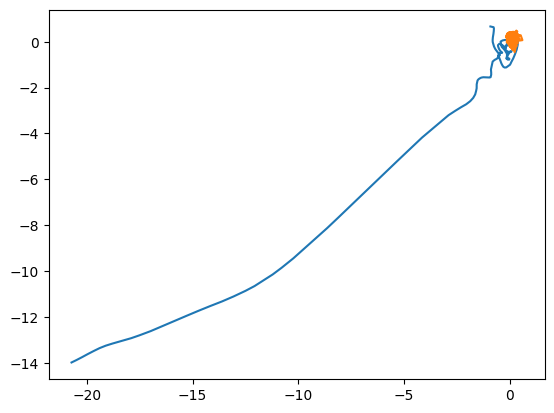

In [70]:
idx = 31
group_idx = dataset_group_idxs[idx]
print(group_idx)
plt.plot(targets[idx,:,0], targets[idx,:,1])
plt.plot(preds[idx,:,0], preds[idx,:,1])
plt.show()

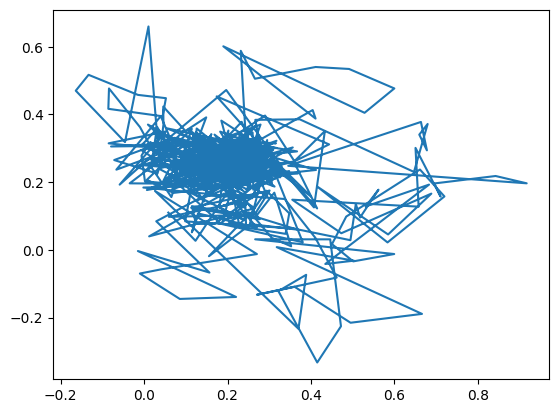

In [36]:
plt.plot(preds[19,:,0], preds[19,:,1])